# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_2m_1f_240219_2"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [90, 1840]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 54172
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,439.948134,128.034305,433.710649,131.950569,0.0,494.0,70.0,0.654902,474.0,104.0,-1.233802,15887.0,240.769132,86.961652,0.932495,3
1,1,0,105.988439,206.822285,107.856729,203.456984,0.0,98.0,85.0,0.596078,87.0,130.0,-0.283455,8131.0,212.253102,109.340234,0.857106,3
2,2,0,597.233382,912.847658,590.949656,911.227200,0.0,501.0,847.0,0.643137,615.0,924.0,1.256412,13043.0,251.850364,86.728338,0.938836,3
3,0,3,120.821414,163.991229,124.877102,155.350786,0.0,156.0,37.0,0.611765,87.0,287.0,-0.322511,12655.0,306.711255,101.141314,0.944065,3
4,1,3,439.821429,128.054263,433.565529,131.984822,0.0,494.0,70.0,0.650980,473.0,104.0,-1.234021,15904.0,241.047799,86.979460,0.932628,3
5,2,3,597.488827,912.966790,591.242556,911.355734,0.0,501.0,847.0,0.643137,678.0,924.0,1.256619,12978.0,251.723945,86.695617,0.938820,3


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([0, 1, 2])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        -tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count  position_x  position_y  orientation
0   0     0         3  439.948134  128.034305    -1.233802
1   1     0         3  105.988439  206.822285    -0.283455
2   2     0         3  597.233382  912.847658     1.256412


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,439.948134,128.034305,433.710649,131.950569,0.0,494.0,70.0,0.654902,474.0,104.0,-1.233802,15887.0,240.769132,86.961652,0.932495,3
1,1,0,105.988439,206.822285,107.856729,203.456984,0.0,98.0,85.0,0.596078,87.0,130.0,-0.283455,8131.0,212.253102,109.340234,0.857106,3
2,2,0,597.233382,912.847658,590.949656,911.227200,0.0,501.0,847.0,0.643137,615.0,924.0,1.256412,13043.0,251.850364,86.728338,0.938836,3
3,0,3,120.821414,163.991229,124.877102,155.350786,0.0,156.0,37.0,0.611765,87.0,287.0,-0.322511,12655.0,306.711255,101.141314,0.944065,3
4,1,3,439.821429,128.054263,433.565529,131.984822,0.0,494.0,70.0,0.650980,473.0,104.0,-1.234021,15904.0,241.047799,86.979460,0.932628,3
5,2,3,597.488827,912.966790,591.242556,911.355734,0.0,501.0,847.0,0.643137,678.0,924.0,1.256619,12978.0,251.723945,86.695617,0.938820,3
6,0,6,120.884393,164.295114,125.049450,155.724804,0.0,156.0,37.0,0.611765,74.0,288.0,-0.323131,12629.0,307.032157,100.815326,0.944555,3


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
37309,3,54168,89.014242,962.849885,90.268544,958.950176,NaN,89.014242,962.849885,NaN,89.014242,962.849885,0.194821,7794.0,188.897429,115.015201,0.793265,4
37310,0,54171,416.889005,98.641361,426.117564,99.930783,0.0,430.000000,58.000000,0.623529,406.000000,72.000000,1.527727,13370.0,241.440760,82.503615,0.939804,4
37311,1,54171,61.481651,530.293578,56.393872,512.272597,NaN,61.481651,530.293578,NaN,61.481651,530.293578,0.342209,436.0,380.718621,84.162048,0.975260,4
37312,2,54171,129.917864,583.979271,138.965169,590.349169,NaN,129.917864,583.979271,NaN,129.917864,583.979271,0.868871,10227.0,247.085093,88.197872,0.934122,4
37313,3,54171,88.998588,962.856391,90.255524,958.959198,NaN,88.998588,962.856391,NaN,88.998588,962.856391,0.194696,7792.0,188.900337,115.004544,0.793316,4


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


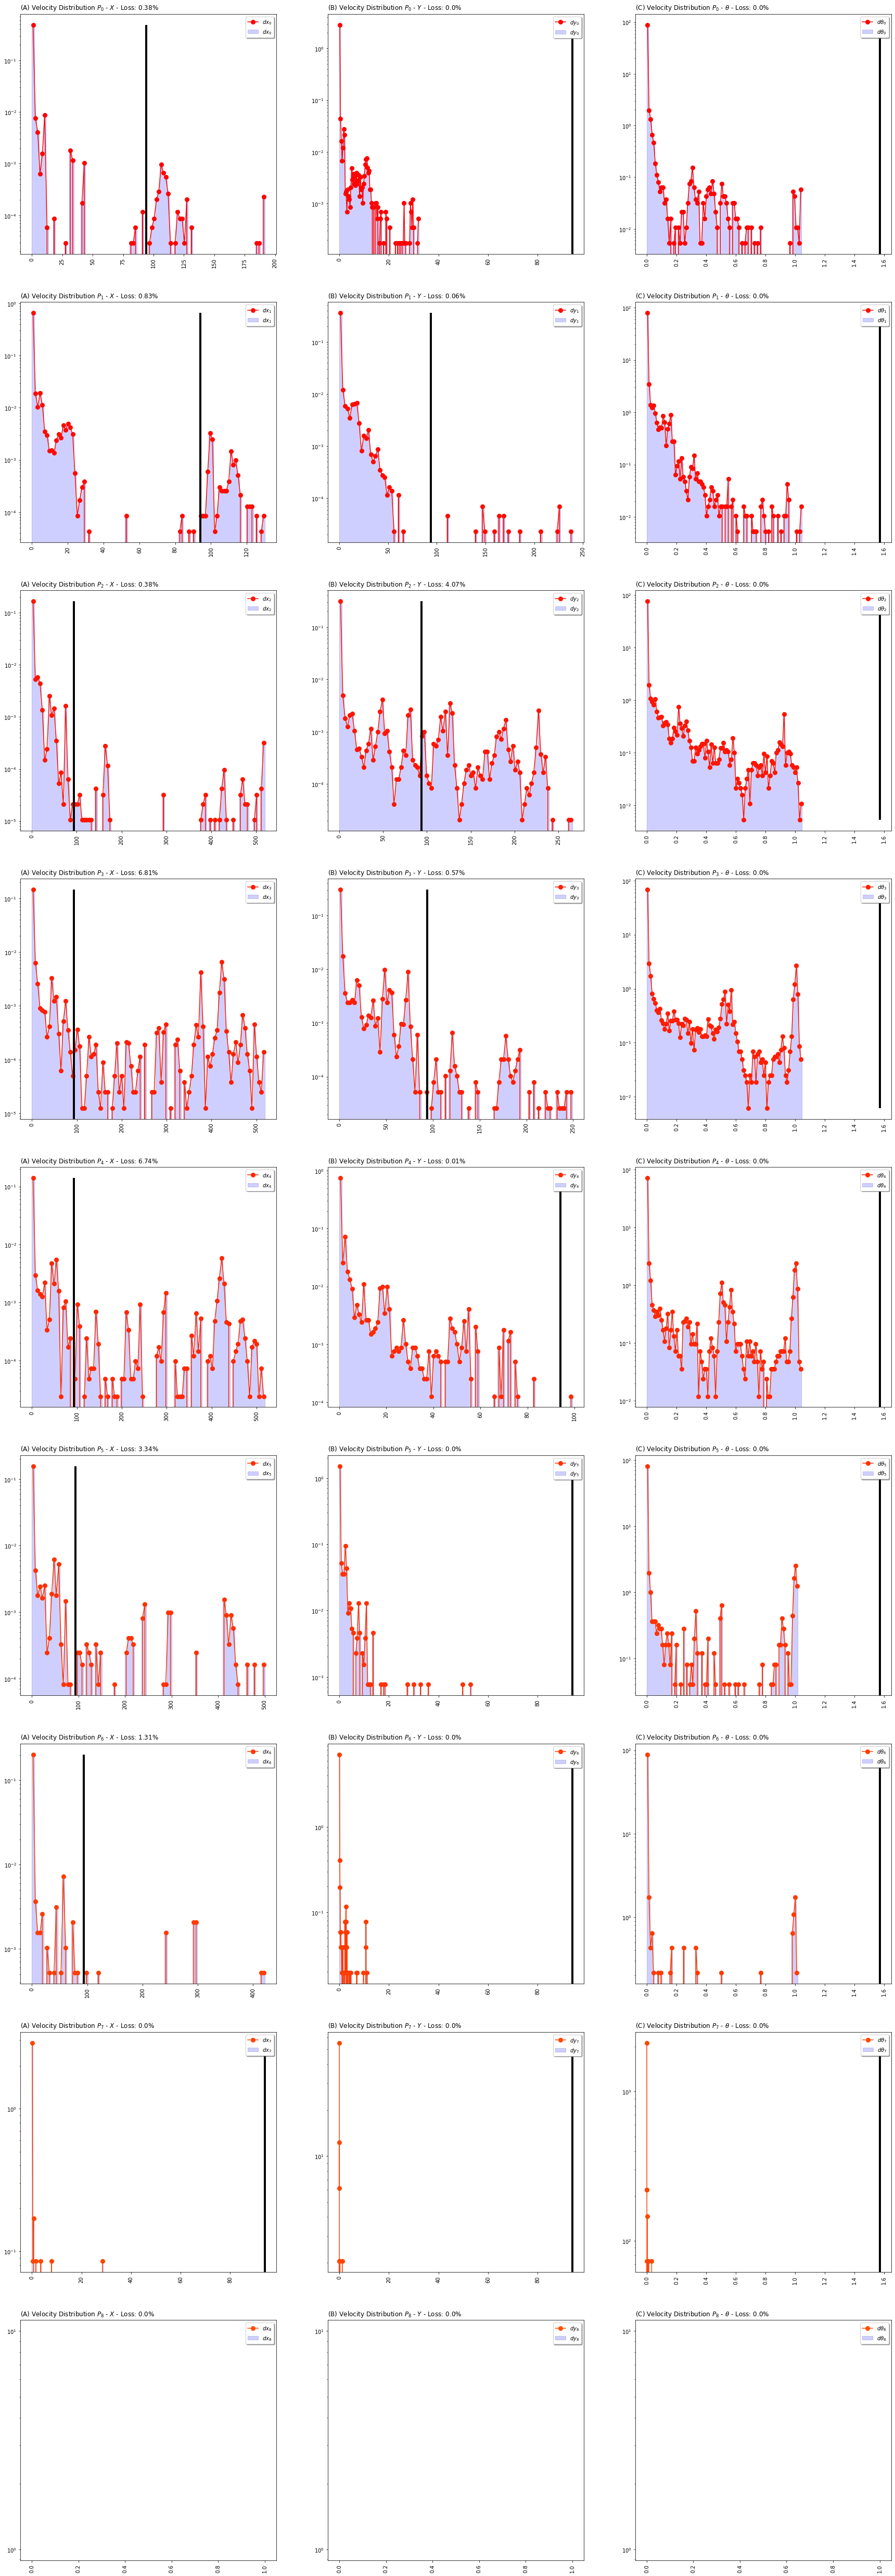

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,3,8124
1,4,29540
2,5,27560
3,6,11970
4,7,2912
5,8,328
6,9,9


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 33.468999910682705 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,9.834293
1,3,False,True,False,0.183981
2,3,True,False,False,0.072101
3,3,True,True,False,0.008702
4,4,False,False,False,35.191378
5,4,False,True,False,0.494760
6,4,True,False,False,1.006924
7,4,True,True,False,0.028592
8,5,False,False,False,33.119103
9,5,False,True,False,0.253596


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 1.0503101969434292 
	- Angle: 33.468999910682705 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0%
Final loss data X-axis: 5.7226191135478395%
Final loss data Y-axis: 7.269572280371417%
Final loss data Angle : 0.15691052408115042%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.123682
1,3,False,False,True,4.709162
2,3,False,True,False,0.016614
3,3,False,True,True,0.873161
4,3,True,False,False,0.001846
5,3,True,False,True,2.434882
6,3,True,True,False,0.014768
7,3,True,True,True,91.825885


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 1.0503101969434292 
	- Angle: 33.468999910682705 



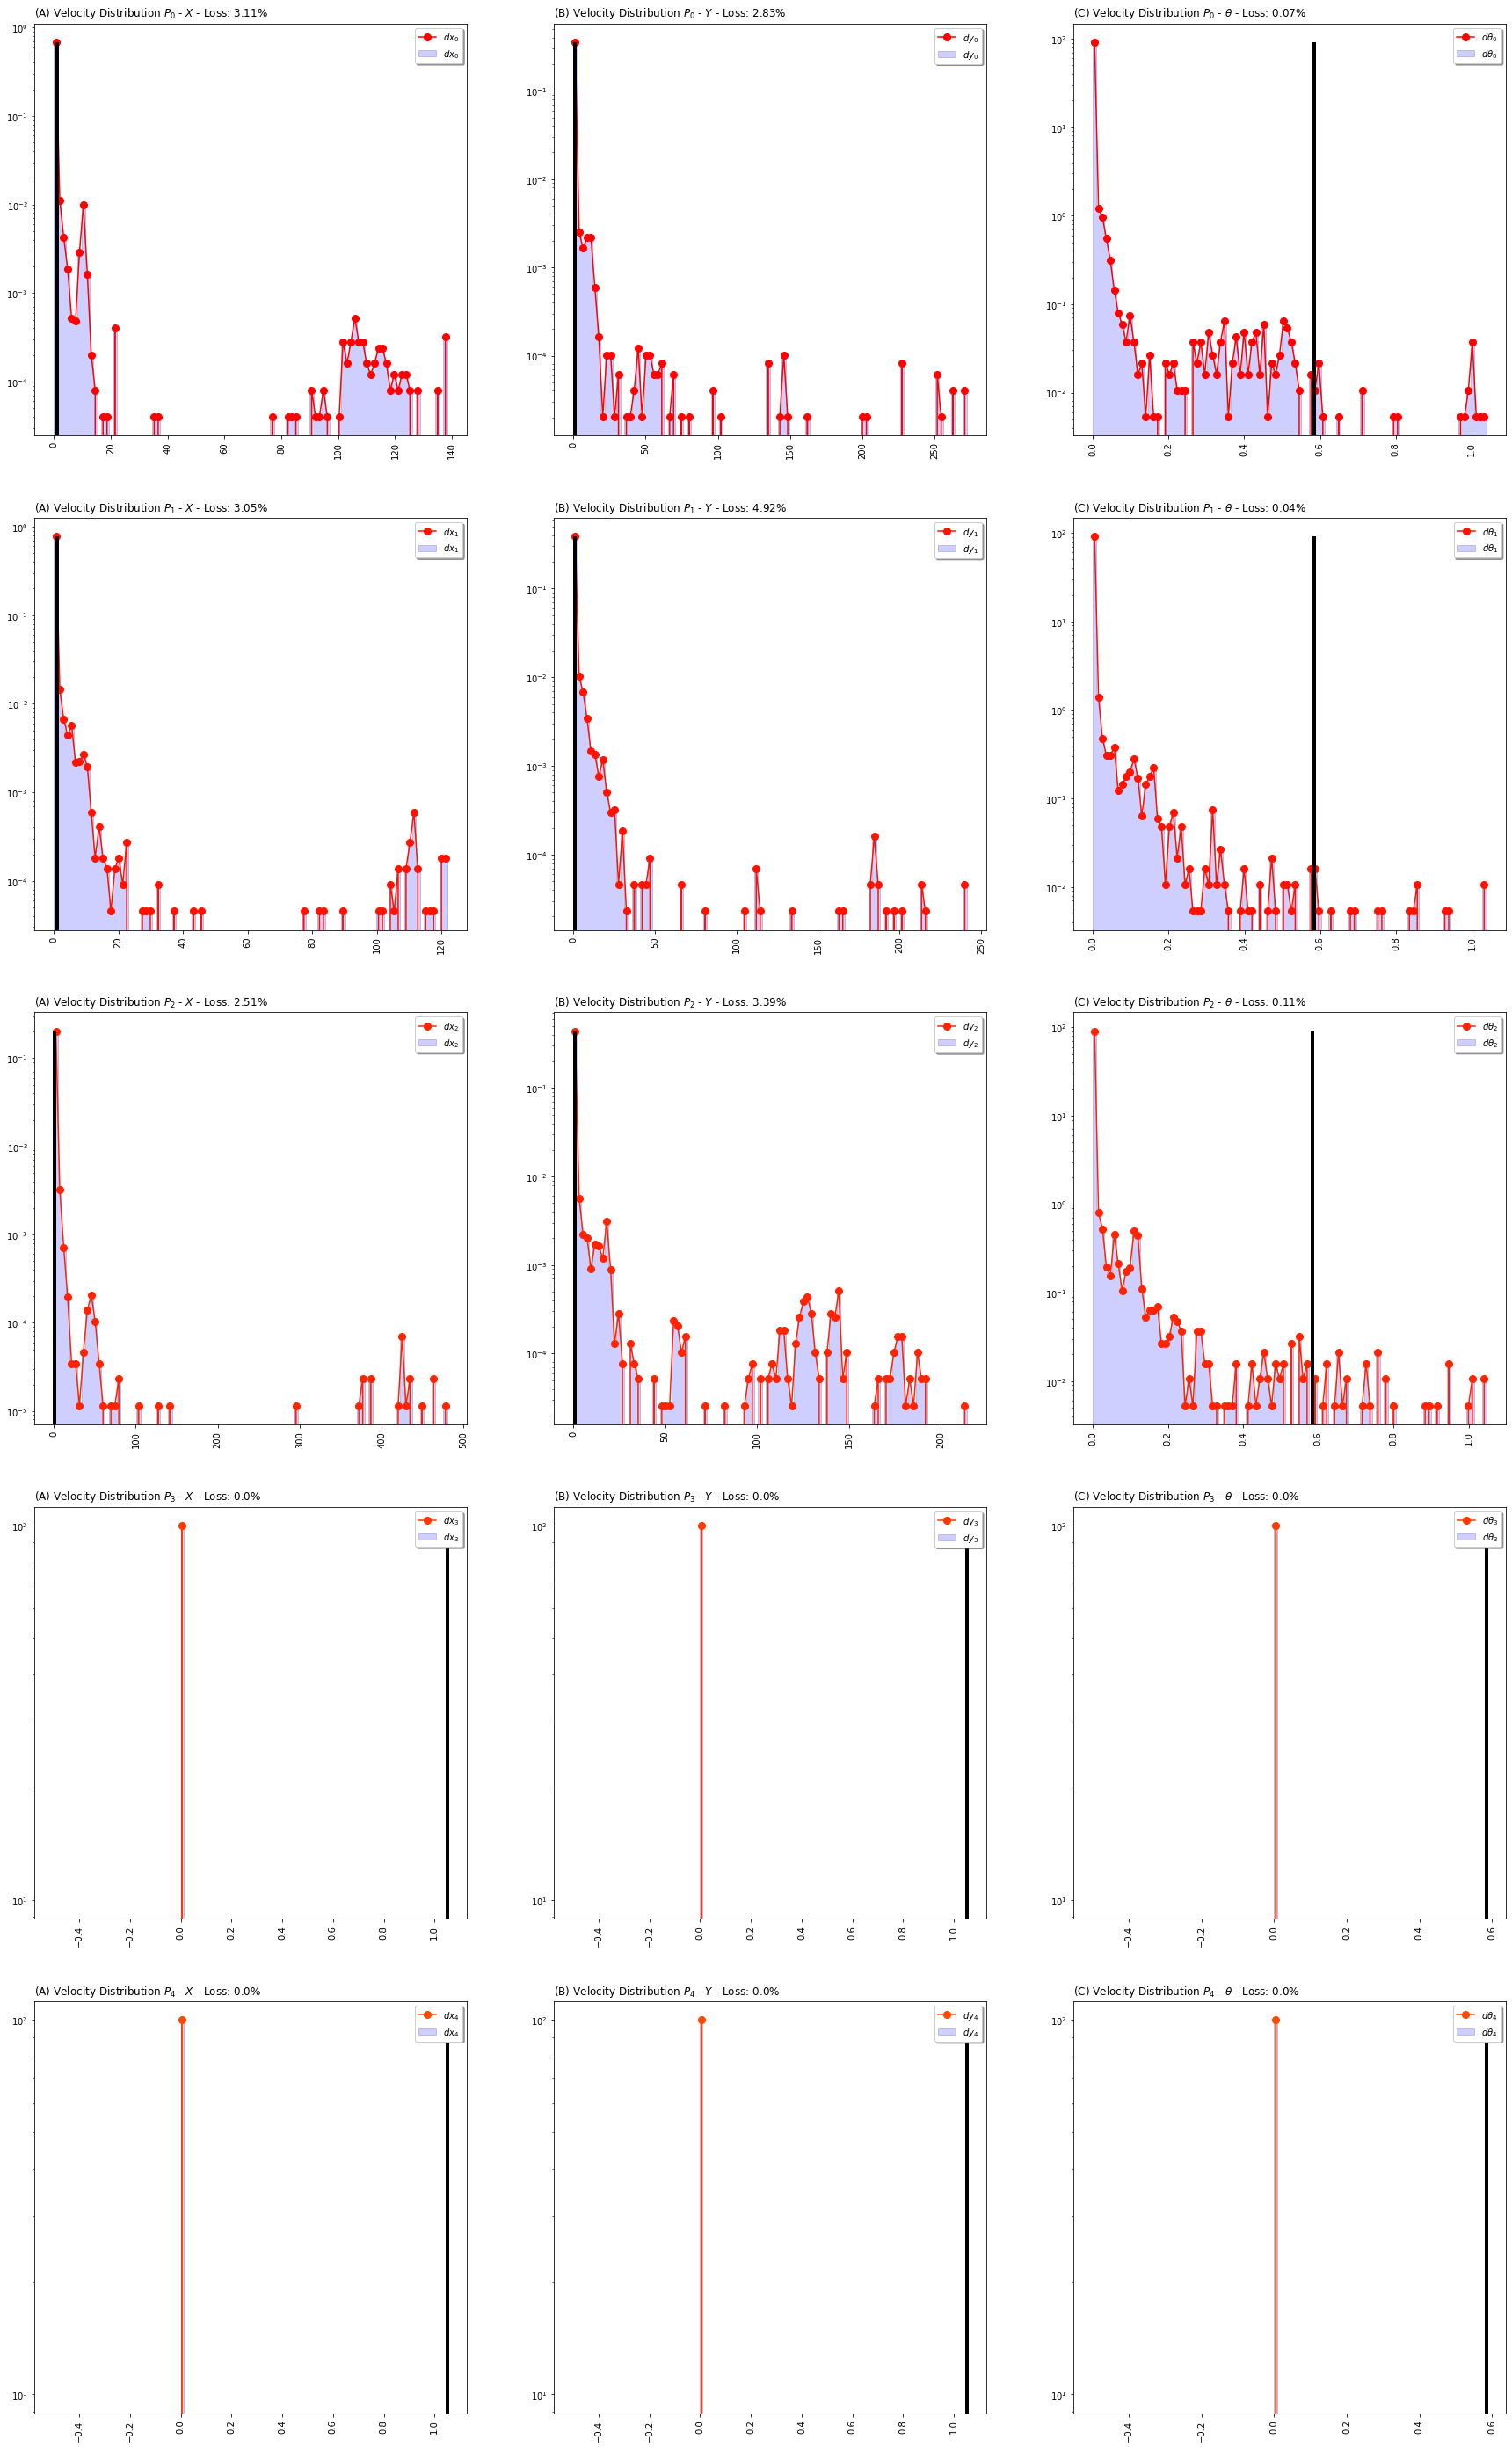

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,439.948134,128.034305,433.710649,131.950569,0.0,494.0,70.0,0.654902,474.0,104.0,-1.233802,15887.0,240.769132,86.961652,0.932495,3,NaN,NaN,NaN,NaN,False,False,False
2708,1,0,105.988439,206.822285,107.856729,203.456984,0.0,98.0,85.0,0.596078,87.0,130.0,-0.283455,8131.0,212.253102,109.340234,0.857106,3,NaN,NaN,NaN,NaN,False,False,False
5416,2,0,597.233382,912.847658,590.949656,911.227200,0.0,501.0,847.0,0.643137,615.0,924.0,1.256412,13043.0,251.850364,86.728338,0.938836,3,NaN,NaN,NaN,NaN,False,False,False
1,0,3,120.821414,163.991229,124.877102,155.350786,0.0,156.0,37.0,0.611765,87.0,287.0,-0.322511,12655.0,306.711255,101.141314,0.944065,3,3.0,-106.375573,11.985641,0.303764,False,True,False
2709,1,3,439.821429,128.054263,433.565529,131.984822,0.0,494.0,70.0,0.650980,473.0,104.0,-1.234021,15904.0,241.047799,86.979460,0.932628,3,3.0,111.277663,-26.256007,-0.316856,True,False,False
5417,2,3,597.488827,912.966790,591.242556,911.355734,0.0,501.0,847.0,0.643137,678.0,924.0,1.256619,12978.0,251.723945,86.695617,0.938820,3,3.0,0.085148,0.039711,0.000069,False,False,False
2,0,6,120.884393,164.295114,125.049450,155.724804,0.0,156.0,37.0,0.611765,74.0,288.0,-0.323131,12629.0,307.032157,100.815326,0.944555,3,3.0,0.020993,0.101295,-0.000206,False,False,False
2710,1,6,439.853872,128.052966,433.600308,131.986086,0.0,494.0,70.0,0.650980,475.0,104.0,-1.233898,15897.0,241.035210,86.953258,0.932663,3,3.0,0.010814,-0.000432,0.000041,False,False,False
5418,2,6,597.491559,912.964850,591.248908,911.357633,0.0,502.0,847.0,0.643137,681.0,924.0,1.256710,12973.0,251.688343,86.659509,0.938855,3,3.0,0.000911,-0.000647,0.000030,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_2m_1f_240219_2_c.zip'